<a href="https://colab.research.google.com/github/Furqan001/Customer-Segmentation-and-Prediction/blob/main/CustomerSegmentationAndPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project | Customer Segmentation and Prediction


<div style="border-radius:10px; padding: 15px; background-color: #facfc8; font-size:120%; text-align:left">

<h3 align="left"><font color=red>Problem:</font></h3>
The e-commerce company currently lacks a deep, data-driven understanding of its diverse customer base and their purchasing behaviors. This results in potentially undifferentiated marketing efforts, inefficient resource allocation, missed opportunities for personalized engagement, and difficulty in identifying high-value or at-risk customer groups. There is a need to leverage customer transaction data to uncover distinct behavioral segments and predict future value to enable more effective and personalized business actions.



<div style="border-radius:10px; padding: 15px; background-color: #facfc8; font-size:115%; text-align:left">

<h3 align="left"><font color=green>Objectives:</font></h3>

- Data Preparation & Exploration: To perform thorough Exploratory Data Analysis (EDA) on the provided e-commerce dataset, clean and preprocess the data (handle missing values, duplicates, outliers), and engineer relevant features, specifically calculating Recency, Frequency, and Monetary (RFM) metrics for each customer.

- Customer Segmentation: To implement, compare, and evaluate multiple unsupervised clustering algorithms (such as K-means, Hierarchical Clustering, DBSCAN) using the derived RFM features to identify distinct, meaningful, and interpretable customer segments based on purchasing patterns.

- Predictive Modeling: To develop and evaluate a supervised classification model capable of predicting future customer behavior or categorizing customers (e.g., identifying potential high-value customers or those at risk of churn) based on their historical RFM data and potentially other relevant features.

- Insight Generation & Feature Importance: To analyze the characteristics (e.g., average RFM values, geographic distribution) of the identified customer segments and determine the relative importance of Recency, Frequency, and Monetary value in distinguishing between segments and predicting customer behavior.

- Actionable Recommendations: To translate the segmentation and predictive modeling results into actionable business strategies, providing specific recommendations for targeted marketing campaigns, personalized customer retention initiatives, and potential inventory management improvements tailored to different customer segments.

- Documentation & Visualization: To comprehensively document the entire process, including data preprocessing steps, model selection rationale, implementation details, results, and key findings in a structured report (Jupyter Notebook, Word/PPT), and optionally, create a dashboard (Power BI/Tableau) to visualize customer segments and model insights.



This notebook performs customer segmentation using RFM analysis and various clustering techniques (KMeans, Agglomerative, DBSCAN). It also builds predictive models to classify customers based on their monetary value.



# Step 1 | Setup and Imports

### Description
This section installs the necessary `kneed` library for finding the optimal number of clusters using the elbow method and imports essential Python libraries like `pandas` for data manipulation and `matplotlib` for visualization.

In [ ]:
!pip install kneed

In [ ]:
import joblib
import pandas as pd
import seaborn as sns
from kneed import KneeLocator
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Step 2 | Data Loading and Initial Inspection

### Description
This section loads the transaction data from a CSV file (`data.csv`). The `encoding="latin1"` is used to handle potential special characters in the dataset. The `data.info()` method is called immediately to get a first overview of the data, including column names, data types, non-null counts, and memory usage.


In [ ]:
data = pd.read_csv("/content/data.csv", encoding="latin1")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Findings
- The dataset contains 541,909 entries and 8 columns.
- Columns include `InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, and `Country`.
- There are significant missing values in `Description` (approx. 1,454 missing) and `CustomerID` (approx. 135,080 missing).
- `CustomerID` is currently a float, likely due to missing values (NaNs); it should ideally be an integer or string.
- `InvoiceDate` is an object (string) and needs conversion to a datetime format for time-based analysis like Recency.



# Step 3 | Data Cleaning and Preprocessing



### 3.1 | Handling Missing Descriptions

### Description
Missing `Description` values can hinder analysis, especially if descriptions are used for product insights. This step imputes missing `Description` values based on the `StockCode`. The strategy is to find the most frequent (mode) description associated with each `StockCode` and use that to fill the NaNs for rows with the same `StockCode`. This assumes that a given `StockCode` usually corresponds to the same product description.

In [ ]:
mode_desc = data[data["Description"].notnull()].groupby(["StockCode"])["Description"].agg(lambda x: x.mode().iloc[0])

data["Description"] = data["Description"].fillna(data["StockCode"].map(mode_desc))

#### Check info again to see the effect of imputation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541797 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Findings
- After imputation, the number of non-null values in the `Description` column increased significantly (from 540,455 to 541,797).
- There are still a small number of rows (112) where `Description` remains null. Let's inspect these.

In [ ]:
data[data["Description"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,12/1/2010 14:35,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
280754,561498,21610,NaN,-14,7/27/2011 14:10,0.0,NaN,United Kingdom
281615,561555,37477B,NaN,-11,7/28/2011 10:21,0.0,NaN,United Kingdom
281616,561557,37477C,NaN,-31,7/28/2011 10:21,0.0,NaN,United Kingdom
346849,567207,35592T,NaN,4,9/19/2011 11:01,0.0,NaN,United Kingdom


#### Findings
- The remaining 112 rows with null `Description` also have `UnitPrice` equal to 0.0 and often have missing `CustomerID` as well.
- These rows likely represent non-standard transactions or data entry issues. Given their small number and lack of key information, we'll drop rows where both `CustomerID` and `Description` are null.

In [ ]:
data.dropna(subset=["CustomerID", "Description"], how="all", inplace=True)

#### Verify the info after dropping remaining Description nulls

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541797 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541797 non-null  object 
 1   StockCode    541797 non-null  object 
 2   Description  541797 non-null  object 
 3   Quantity     541797 non-null  int64  
 4   InvoiceDate  541797 non-null  object 
 5   UnitPrice    541797 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541797 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


#### Findings
- The 112 rows with remaining null Descriptions have been removed.
- The dataset now has 541,797 entries.
- `CustomerID` still has a large number of missing values.

### 3.2 | Handling Missing Customer IDs

### Description
`CustomerID` is crucial for customer-level analysis like segmentation and RFM. Transactions without a `CustomerID` cannot be attributed to a specific customer and are therefore removed from the dataset for this analysis. We also convert the `CustomerID` column to an integer type after handling NaNs.


#### Display rows with missing CustomerID to understand their nature

In [ ]:
data[data["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


#### Drop rows with missing CustomerID

In [ ]:
data.dropna(subset=['CustomerID'], inplace=True)

#### Verify that there are no more missing CustomerIDs

In [ ]:
data[data["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


#### Convert CustomerID to integer type

In [ ]:
data["CustomerID"] =data["CustomerID"].astype(int)

#### Findings
- Approximately 134,968 rows had missing `CustomerID` values.
- These rows have been removed, leaving 406,829 entries with valid customer IDs.
- The `CustomerID` column has been successfully converted to the `int` data type.

### 3.3 | Converting Invoice Date

### Description
The `InvoiceDate` column is converted from an object (string) type to a datetime object. This is essential for performing date-based calculations, particularly for determining the Recency component of the RFM analysis.

#### Convert InvoiceDate to datetime objects

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

#### Findings
- The `InvoiceDate` column is now in datetime format, suitable for calculations.

### 3.4 | Handling Duplicate Rows

### Description
Duplicate rows can skew analysis results (e.g., inflating frequency or monetary values). This step identifies and removes any complete duplicate rows from the dataset.

In [ ]:
data.duplicated().sum()
data.drop_duplicates(inplace=True)

#### Check for null values again after dropping duplicates

In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


#### Findings
- 5,225 duplicate rows were identified and removed.
- The dataset now has 401,604 unique transaction entries.
- There are no remaining null values in any column.

### 3.5 | Handling Zero Unit Prices

### Description
Transactions with a `UnitPrice` of 0 or less are unusual and can distort monetary calculations. They might represent free items, cancellations, or data errors. These rows are identified and removed from the analysis dataset. The commented-out code shows an alternative approach where zero prices could potentially be imputed using the mode price for the corresponding `StockCode`, but removal is chosen here for simplicity and to avoid potentially inaccurate imputations.

#### Count rows where UnitPrice is zero or negative

In [ ]:
len(data[data["UnitPrice"] <= 0])

40

In [ ]:
# stockUnitPrice = data.groupby("StockCode")["UnitPrice"].agg(lambda x: x.mode().iloc[0])

# data["UnitPrice_Filled"] = False
# zero_price_rows = data["UnitPrice"] == 0
# data.loc[zero_price_rows, "UnitPrice"] = data.loc[zero_price_rows, "StockCode"].map(stockUnitPrice)
# data[data["UnitPrice"] == 0]
# data.loc[zero_price_rows, "UnitPrice_Filled"] = True
# data["UnitPrice"].isnull().sum()

#### Display rows with zero UnitPrice

In [ ]:
data[data["UnitPrice"] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410,United Kingdom


#### Findings
- There are 40 rows with a `UnitPrice` of 0.
- These rows often involve specific stock codes like 'M' (Manual) or 'PADS', suggesting they might be adjustments or non-standard entries rather than regular product sales.
- These 40 rows will be removed.

#### Remove rows with UnitPrice <= 0

In [ ]:
data = data[data["UnitPrice"] > 0]

#### Verify removal by checking a previously affected StockCode (e.g., 22841)

In [ ]:
data[data["StockCode"] == "22841"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 13:06:00,7.95,15827,United Kingdom
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 18:49:00,7.95,14236,United Kingdom
5328,536859,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-03 10:43:00,7.95,12841,United Kingdom
9543,537207,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 15:06:00,7.95,17402,United Kingdom
9837,537219,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 15:47:00,7.95,14081,United Kingdom
...,...,...,...,...,...,...,...,...
503063,578858,22841,ROUND CAKE TIN VINTAGE GREEN,1,2011-11-27 11:22:00,7.95,18145,United Kingdom
504274,578946,22841,ROUND CAKE TIN VINTAGE GREEN,1,2011-11-27 13:47:00,7.95,16005,United Kingdom
509600,579387,22841,ROUND CAKE TIN VINTAGE GREEN,1,2011-11-29 12:06:00,7.95,14452,United Kingdom
516920,580021,22841,ROUND CAKE TIN VINTAGE GREEN,2,2011-12-01 11:43:00,7.95,14047,United Kingdom


#### Findings
- The 40 rows with zero `UnitPrice` have been successfully removed.
- The dataset now contains 401,564 rows, ready for further analysis.

# Step 4 | Exploratory Data Analysis (EDA)

### Description
This section explores the cleaned data visually to understand distributions and patterns. We focus on the geographic distribution of customers and the distributions of `Quantity` and `UnitPrice`.



### 4.1 | Country Distribution

#### Create a copy of the dataframe for EDA to avoid modifying the main cleaned data yet

In [ ]:
df = data.copy()

#### Analyze and plot the distribution of customers by country

In [ ]:
print(data["Country"].value_counts())

Country
United Kingdom          356704
Germany                   9478
France                    8474
EIRE                      7473
Spain                     2527
Netherlands               2367
Belgium                   2069
Switzerland               1876
Portugal                  1471
Australia                 1255
Norway                    1085
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         57
Lebanon                     45


#### Plot the top 20 countries by customer count

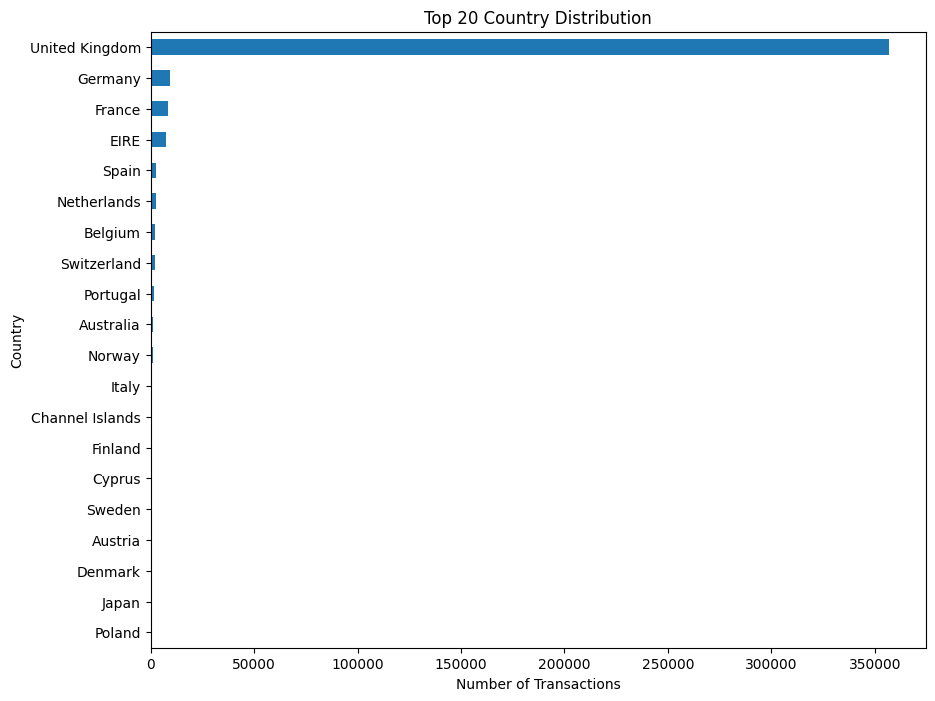

In [ ]:
plt.figure(figsize=(10, 8)) # Adjusted figure size for better readability
df['Country'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh')
plt.title("Top 20 Country Distribution")
plt.xlabel("Number of Transactions") # Added x-axis label
plt.show()

#### Findings
- The vast majority of transactions (and likely customers) are from the United Kingdom (approx. 356k transactions).
- Germany, France, and EIRE are the next most frequent countries, but significantly less common than the UK.
- This heavy skew towards the UK might influence segmentation results. Depending on the business goal, analysis might be focused solely on UK customers or might require careful handling of the imbalance if analyzing globally.



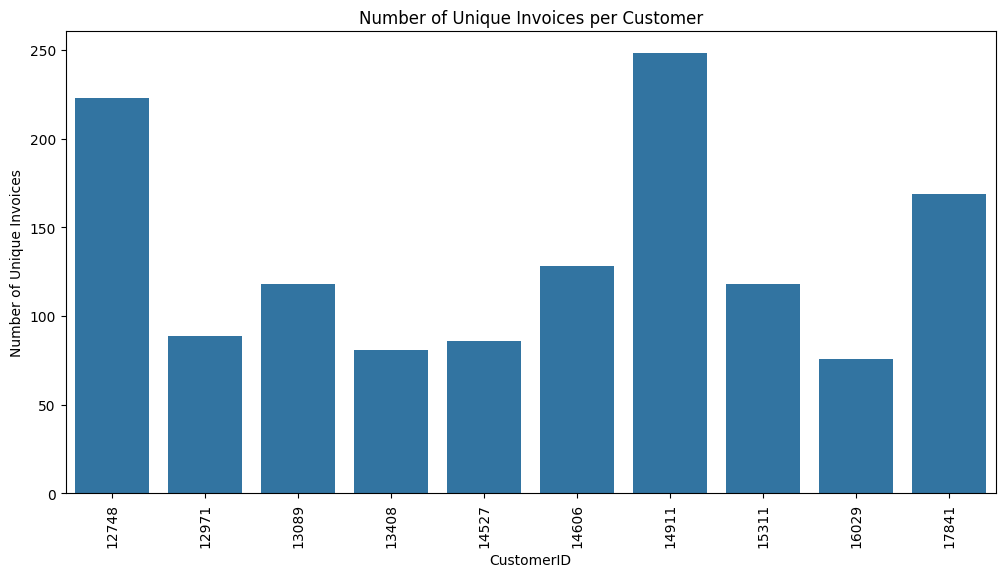

In [ ]:


customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": lambda x: x.nunique(),
    "Country": lambda x: x.mode()[0]
}).sort_values(ascending=False, by="InvoiceNo").head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=customer_df.index, y="InvoiceNo", data=customer_df)  # Changed 'InvoiceNo' to 'InvoiceNo'
plt.xticks(rotation=90)
plt.xlabel("CustomerID")
plt.ylabel("Number of Unique Invoices")
plt.title("Number of Unique Invoices per Customer")
plt.show()


In [ ]:
df.groupby("CustomerID").agg({
    "InvoiceNo": lambda x: x.nunique(),
    "Country": lambda x: x.mode()[0]
}).sort_values(ascending=False, by="InvoiceNo")

,InvoiceNo,Country
CustomerID,,
14911,248,EIRE
12748,223,United Kingdom
17841,169,United Kingdom
14606,128,United Kingdom
13089,118,United Kingdom
...,...,...
12361,1,Belgium
12357,1,Switzerland
12355,1,Bahrain


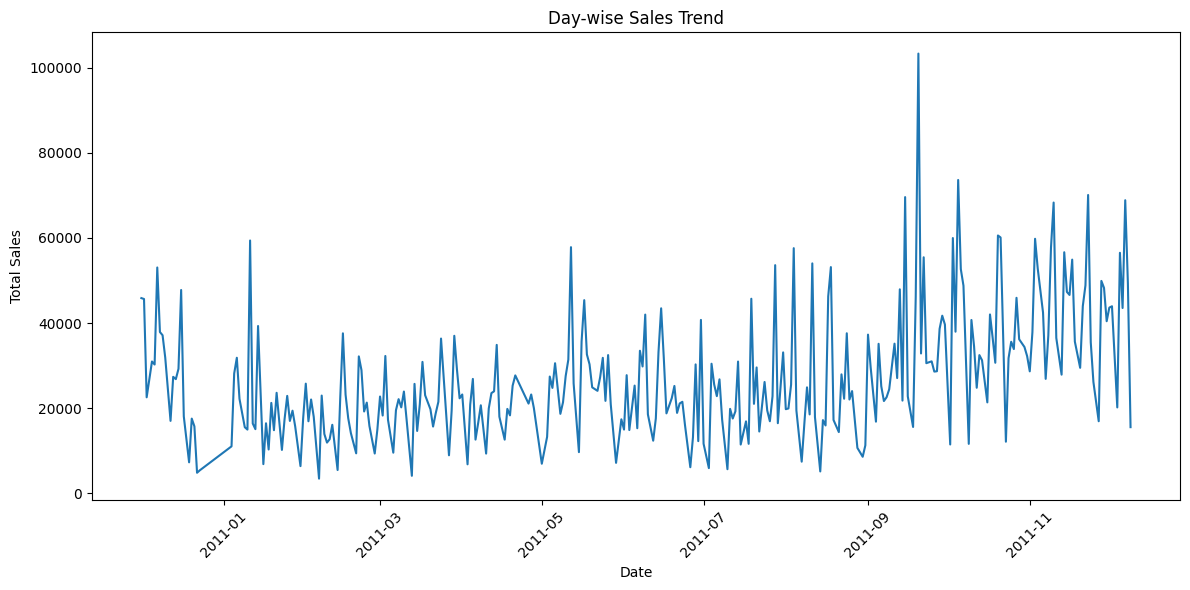

In [ ]:

data["Total_Price"] = data["Quantity"] * data["UnitPrice"]
data["Date"] = data["InvoiceDate"].dt.date
daily_sales = data.groupby("Date")["Total_Price"].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Day-wise Sales Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
product_sales = data.groupby('Description')['Quantity'].sum()
product_sales

,Quantity
Description,
4 PURPLE FLOCK DINNER CANDLES,138
50'S CHRISTMAS GIFT BAG LARGE,1883
DOLLY GIRL BEAKER,2387
I LOVE LONDON MINI BACKPACK,359
I LOVE LONDON MINI RUCKSACK,1
...,...
ZINC T-LIGHT HOLDER STARS SMALL,4850
ZINC TOP 2 DOOR WOODEN SHELF,5
ZINC WILLIE WINKIE CANDLE STICK,2594


Product with highest sales: WORLD WAR 2 GLIDERS ASSTD DESIGNS (Quantity: 53119)
Product with lowest sales: ROTATING SILVER ANGELS T-LIGHT HLDR (Quantity: -1475)


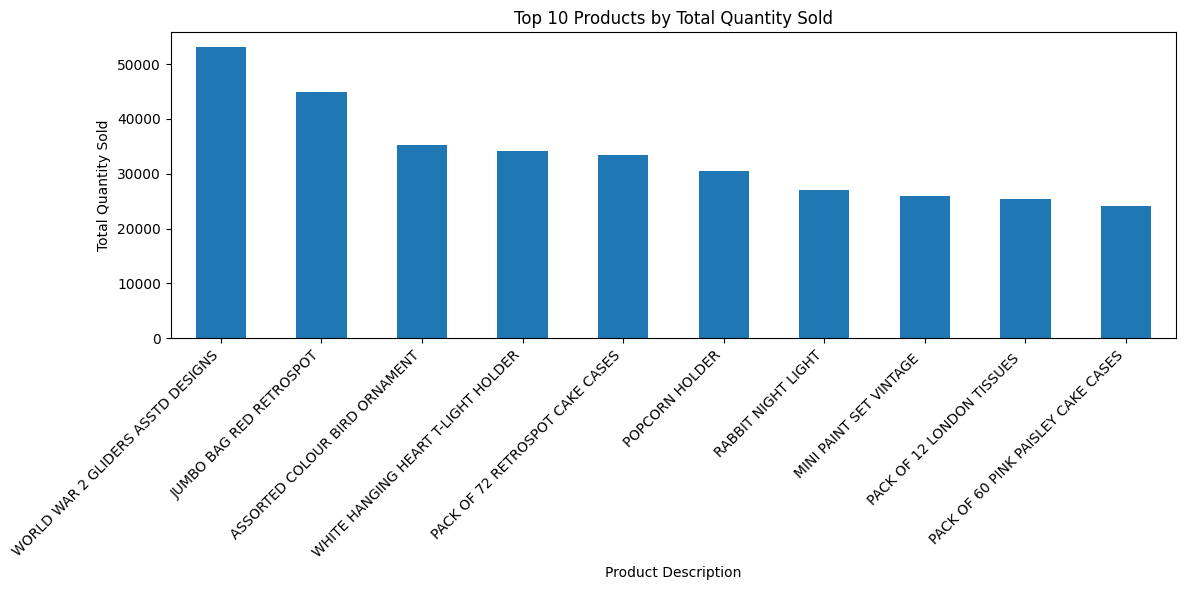

In [ ]:

top_product = product_sales.idxmax()
top_sales = product_sales.max()

bottom_product = product_sales.idxmin()
bottom_sales = product_sales.min()

print(f"Product with highest sales: {top_product} (Quantity: {top_sales})")
print(f"Product with lowest sales: {bottom_product} (Quantity: {bottom_sales})")

# # Plotting
plt.figure(figsize=(12, 6))
product_sales.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Products by Total Quantity Sold')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()


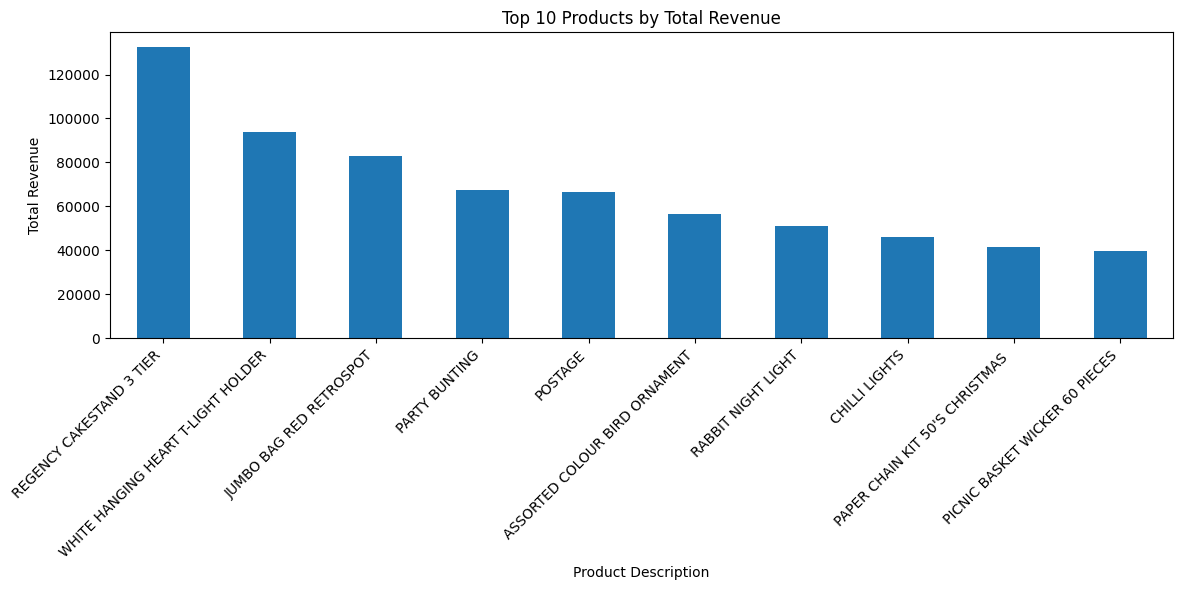

,Total_Price
Description,
REGENCY CAKESTAND 3 TIER,132567.70
WHITE HANGING HEART T-LIGHT HOLDER,93767.80
JUMBO BAG RED RETROSPOT,83056.52
PARTY BUNTING,67628.43
POSTAGE,66710.24
ASSORTED COLOUR BIRD ORNAMENT,56331.91
RABBIT NIGHT LIGHT,51042.84
CHILLI LIGHTS,45915.41
PAPER CHAIN KIT 50'S CHRISTMAS,41423.78


In [ ]:

product_revenue = data.groupby('Description')['Total_Price'].sum()

# Get the top 10 products by revenue
top_10_products = product_revenue.sort_values(ascending=False).head(10)

# Plotting the top 10 products
plt.figure(figsize=(12, 6))
top_10_products.plot(kind='bar')
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Product Description')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the top 10 products with their revenue
top_10_products


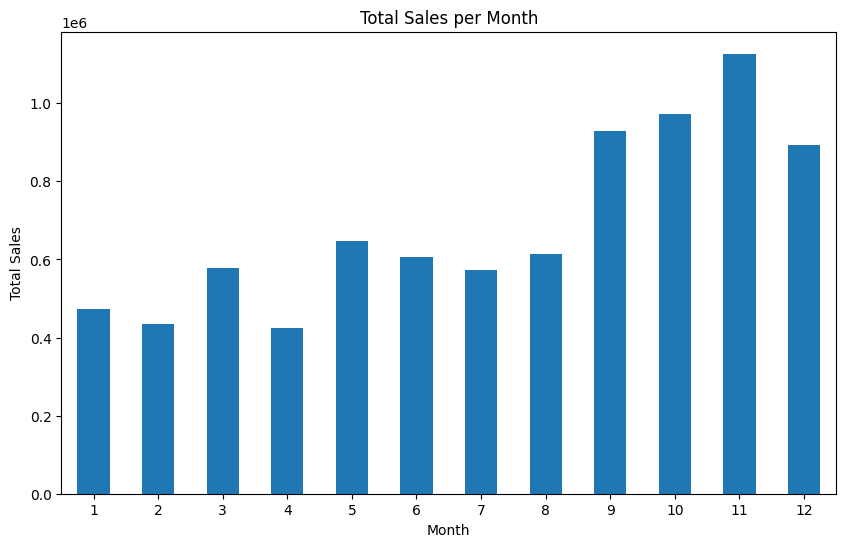

The month with the highest sales is: 11


In [ ]:


# Extract the month from the 'InvoiceDate' column
data['Month'] = data['InvoiceDate'].dt.month

# Calculate total sales for each month
monthly_sales = data.groupby('Month')['Total_Price'].sum()

# Create the plot
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales per Month')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()

# Find the month with the highest sales
highest_sales_month = monthly_sales.idxmax()
print(f"The month with the highest sales is: {highest_sales_month}")


### 4.2 | Quantity and UnitPrice Distributions (Initial Look Post-Cleaning)

#### Plot histograms for Quantity and UnitPrice using log scale due to potential skewness

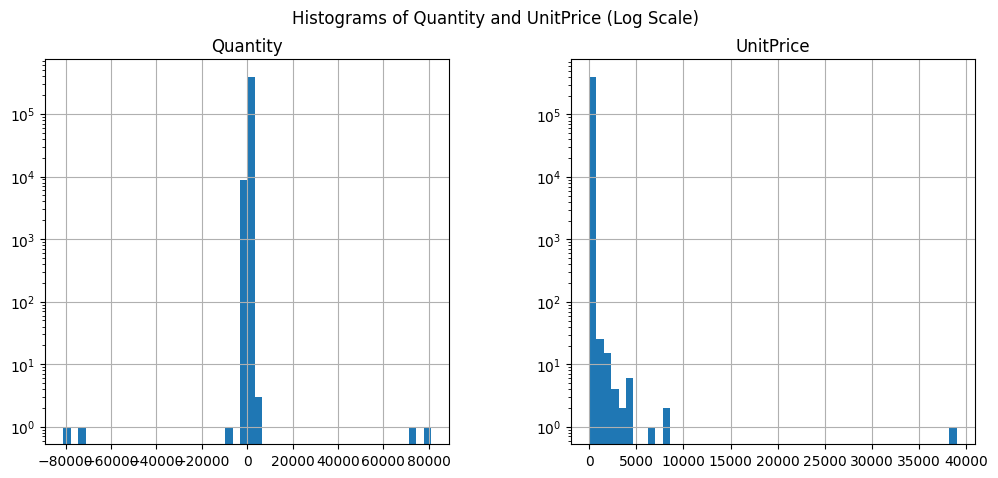

In [ ]:
data[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
plt.suptitle("Histograms of Quantity and UnitPrice (Log Scale)")
plt.show()

#### Plot boxplots for Quantity and UnitPrice to visualize spread and outliers

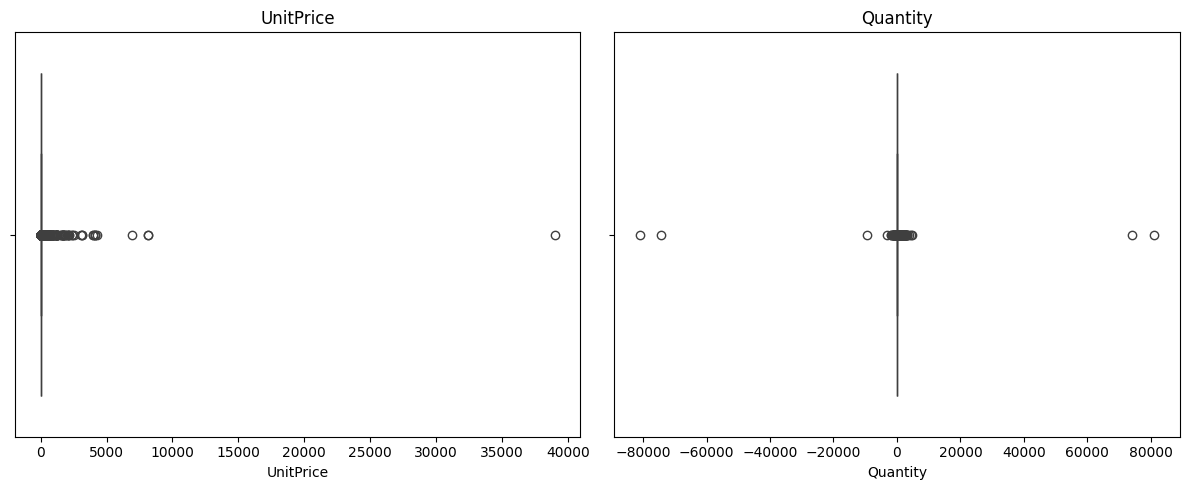

In [ ]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=data["UnitPrice"])
plt.title("UnitPrice")

plt.subplot(1, 2, 2)
sns.boxplot(x=data["Quantity"])
plt.title("Quantity")

plt.tight_layout()
plt.show()

#### Findings
- **Histograms (Log Scale):** Both `Quantity` and `UnitPrice` distributions appear heavily right-skewed even on a log scale, indicating that most transactions involve small quantities and low unit prices, but there are transactions with very high values.
- **Boxplots:** The boxplots confirm the presence of numerous outliers, especially for higher values in both `Quantity` and `UnitPrice`. Negative quantities (likely returns/cancellations) were likely removed earlier, but high positive quantities and prices remain. These outliers could disproportionately affect clustering algorithms based on distance or variance.

### 4.3 | Outlier Handling using IQR

### Description
To mitigate the impact of extreme outliers identified in the EDA, the Interquartile Range (IQR) method is applied. Values falling below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers and removed. This is done separately for `Quantity` and `UnitPrice`. Different quantile ranges (e.g., 0.30-0.70 for Quantity, 0.25-0.65 for UnitPrice) are used, likely chosen through experimentation to retain a reasonable amount of data while removing the most extreme values.


In [ ]:
q1 = df["Quantity"].quantile(0.30)
q3 = df["Quantity"].quantile(0.70)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df = df.loc[(df["Quantity"] < upper_limit) & (df["Quantity"] > lower_limit)]
q1 = df["UnitPrice"].quantile(0.25)
q3 = df["UnitPrice"].quantile(0.65)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df = df.loc[(df["UnitPrice"] < upper_limit) & (df["UnitPrice"] > lower_limit)]

#### Findings
- Outliers beyond the 1.5 * IQR range (using specific quantiles) for both `Quantity` and `UnitPrice` have been removed. This should result in a dataset with less extreme values, making subsequent analysis like clustering more robust.

### 4.4 | Quantity and UnitPrice Distributions (After Outlier Removal)

#### Re-plot boxplots after outlier removal to visualize the effect

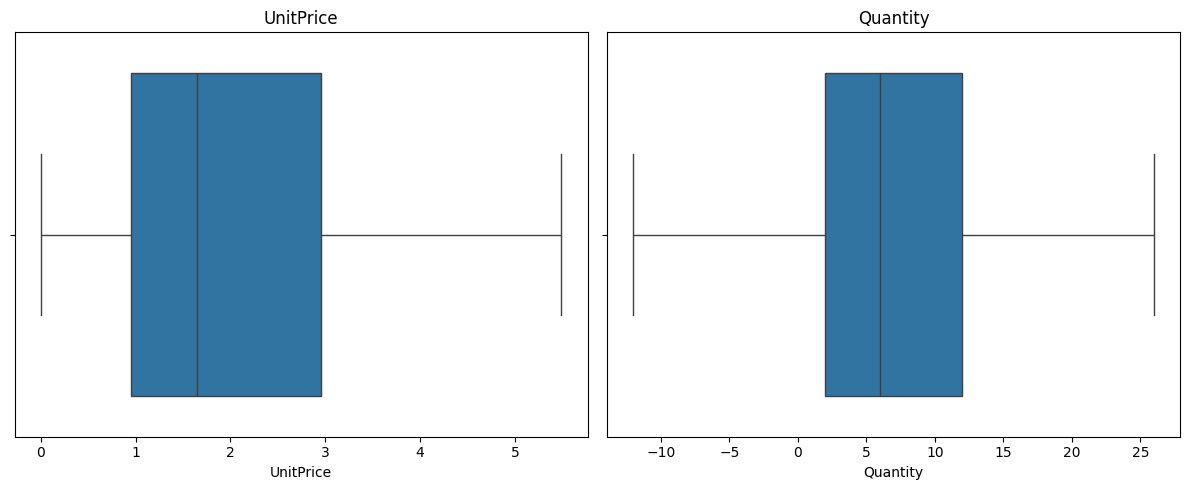

In [ ]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df["UnitPrice"])
plt.title("UnitPrice")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["Quantity"])
plt.title("Quantity")

plt.tight_layout()
plt.show()

#### Re-plot histograms after outlier removal

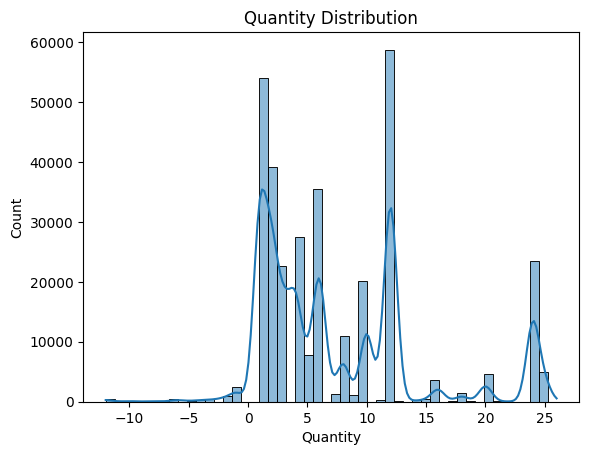

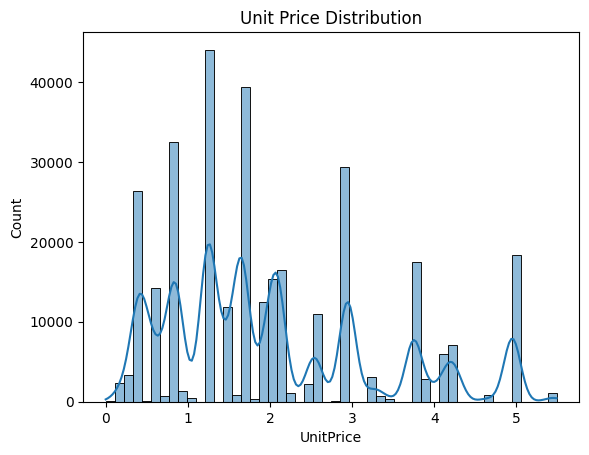

In [ ]:


sns.histplot(df["Quantity"], bins=50, kde=True)
plt.title("Quantity Distribution")
plt.show()

sns.histplot(df["UnitPrice"], bins=50, kde=True)
plt.title("Unit Price Distribution")
plt.show()

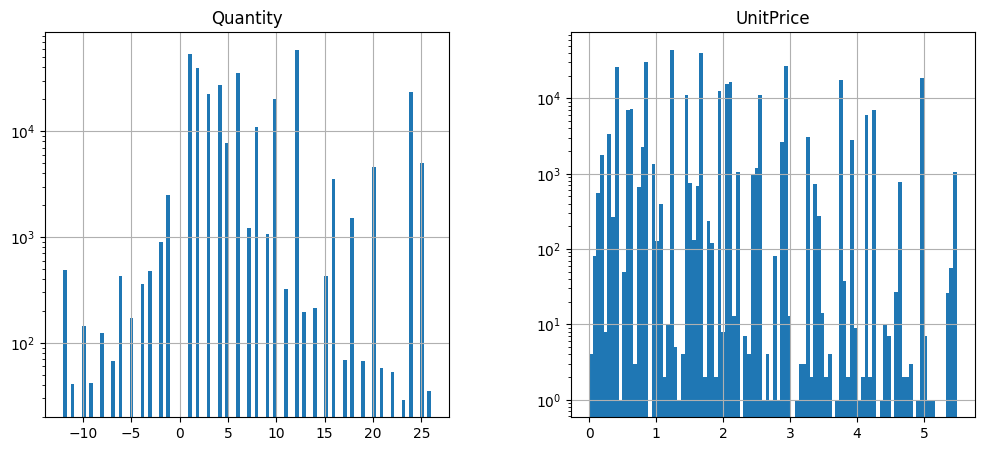

In [ ]:
df[['Quantity', 'UnitPrice']].hist(bins=100, figsize=(12, 5), layout=(1, 2), log=True)
plt.show()

#### Findings
- **Boxplots:** The boxplots show a much tighter distribution for both `Quantity` and `UnitPrice` after applying the IQR filter. While some values might still appear as outliers relative to the *new* distribution, the extreme values have been effectively removed.
- **Histograms:** The histograms (especially without log scale, shown in the seaborn plots) are still skewed but cover a much narrower range, confirming the outlier removal. The log-scale histograms also show a more concentrated distribution.
- The data is now better prepared for RFM calculation and clustering, as extreme values are less likely to dominate the results.

# Step 5 | RFM Analysis and Segmentation

### Description
This section performs Recency, Frequency, and Monetary (RFM) analysis to quantify customer value based on their transaction history.
- **Recency (R):** Days since the customer's last purchase. Lower is better.
- **Frequency (F):** Total number of transactions (or purchases). Higher is better.
- **Monetary (M):** Total monetary value of purchases. Higher is better.


A `Total_Price` column is calculated first. Then, RFM values are computed for each customer.



### 5.1 | Calculate RFM Metrics

#### Calculate Total_Price for each transaction line

In [ ]:
df["Total_Price"] = df["Quantity"] * df["UnitPrice"]

#### Calculate Recency, Frequency, and Monetary values for each customer

In [ ]:
latest_date = df["InvoiceDate"].max()

df_rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,
    "InvoiceNo": "count",
    "Total_Price": "sum"
})

df_rfm = df_rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total_Price': 'Monetary'
})

#### Display summary statistics for RFM metrics

In [ ]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,4208.000000,4208.000000,4208.000000
mean,91.314876,76.921340,922.722308
std,100.782109,192.214683,1943.922182
min,0.000000,1.000000,-222.790000
25%,16.000000,14.000000,181.290000
50%,49.000000,34.000000,423.100000
75%,144.000000,84.000000,1031.502500
max,373.000000,7008.000000,76303.530000


#### Findings
- The `df_rfm` DataFrame now contains the Recency, Frequency, and Monetary values for each of the 4208 unique customers remaining after cleaning.
- **Recency:** Ranges from 0 (most recent) to 373 days. The average recency is about 91 days.
- **Frequency:** Ranges from 1 to 7008 transactions/items. The mean (77) is much higher than the median (34), indicating a right skew (many customers buy infrequently, a few buy very often).
- **Monetary:** Ranges from -222.79 (likely due to returns dominating for some filtered period) to 76,303. The mean (922) is also higher than the median (423), indicating skewness towards higher spending by some customers. Negative monetary values should ideally be handled (e.g., set to 0 or remove those customers) before scoring if they cause issues, but qcut handles them.

In [ ]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4208 entries, 12347 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4208 non-null   int64  
 1   Frequency  4208 non-null   int64  
 2   Monetary   4208 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 131.5 KB


### 5.2 | RFM Segmentation using Quantiles

### Description
Customers are segmented based on their RFM metrics using quantiles (`pd.qcut`). Each metric (R, F, M) is divided into 4 quantiles (quartiles).
- **Recency:** Scored 4 (most recent) to 1 (least recent).
- **Frequency & Monetary:** Scored 1 (lowest) to 4 (highest).
An overall `RFM_score` is calculated by summing the individual R, F, and M segment scores.

*Note: The code merges the customer's country back into this segmented dataframe.*


In [ ]:
df_rfm_seg = df_rfm.copy()

df_rfm_seg['R_seg'] = pd.qcut(df_rfm_seg['Recency'], q=4, labels=[4, 3, 2, 1])
df_rfm_seg['F_seg'] = pd.qcut(df_rfm_seg['Frequency'], q=4, labels=[1, 2, 3, 4])
df_rfm_seg['M_seg'] = pd.qcut(df_rfm_seg['Monetary'], q=4, labels=[1, 2, 3, 4])

df_rfm_seg['RFM_score'] = df_rfm_seg[['R_seg','F_seg','M_seg']].sum(axis=1)

df_rfm_seg.head()

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score
CustomerID,,,,,,,
12347,1,164,3243.33,4,4,4,12
12348,248,6,90.20,1,1,1,3
12349,18,53,918.10,3,3,3,9
12350,309,16,294.40,1,2,2,5
12352,35,66,866.01,3,3,3,9


#### Display the top customers based on RFM score

In [ ]:
df_rfm_seg.sort_values('RFM_score', ascending=False).head()

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score
CustomerID,,,,,,,
18245,6,158,2224.78,4,4,4,12
12347,1,164,3243.33,4,4,4,12
18241,9,88,1646.69,4,4,4,12
12359,7,156,2718.93,4,4,4,12
12362,2,223,3888.74,4,4,4,12


#### Get unique CustomerID and Country mapping from the original filtered dataframe

In [ ]:
df_customer_country = df[['CustomerID','Country']].drop_duplicates()
df_customer_country

,CustomerID,Country
0,17850,United Kingdom
10,13047,United Kingdom
26,12583,France
86,14688,United Kingdom
105,17809,United Kingdom
...,...,...
536969,13436,United Kingdom
537255,15520,United Kingdom
538064,13298,United Kingdom
538812,14569,United Kingdom


#### Merge country information back into the RFM segmented dataframe

In [ ]:
df_rfm_seg_country=df_rfm_seg.merge(df_customer_country, on='CustomerID', how='left')

df_rfm_seg_country.head()

,CustomerID,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Country
0,12347,1,164,3243.33,4,4,4,12,Iceland
1,12348,248,6,90.20,1,1,1,3,Finland
2,12349,18,53,918.10,3,3,3,9,Italy
3,12350,309,16,294.40,1,2,2,5,Norway
4,12352,35,66,866.01,3,3,3,9,Norway


#### Save intermediate RFM dataframes (optional but good practice)

In [ ]:
df_rfm.to_csv('df_rfm.csv', index=False)
df_rfm_seg.to_csv('df_rfm_seg.csv', index=False)
df_rfm_seg_country.to_csv('df_rfm_seg_country.csv', index=False)

#### Findings
- RFM segment scores (1-4) and a total `RFM_score` (3-12) have been calculated for each customer.
- Customers with a score of 12 represent the best customers (recent, frequent, high spenders).
- Customers with a score of 3 represent the least valuable or potentially churned customers (not recent, infrequent, low spenders).
- Country information has been successfully merged back.

### 5.3 | RFM Segmentation using Manual Labels

### Description
Based on the calculated `RFM_score`, customers are assigned to named segments (e.g., 'Champions', 'Loyal Customers', 'Potential Loyalist', 'At Risk') to provide more intuitive business categories. The distribution of these segments is visualized using a pie chart.

*Note: This segmentation is based purely on the summed RFM score, which is a simplification. More advanced RFM segmentation might consider R, F, and M scores individually.*

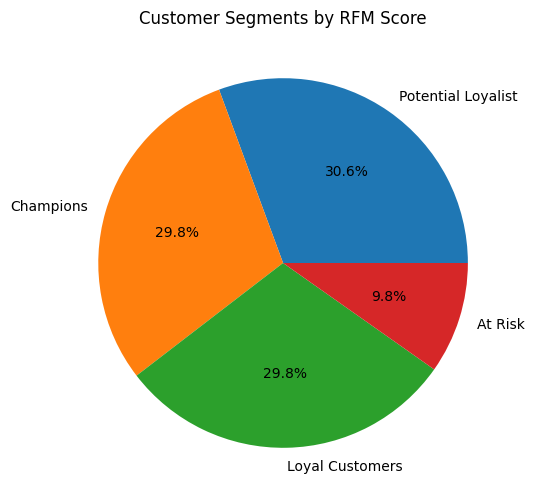

In [ ]:
def segment_customer(row):
    if row['RFM_score'] >= 10:
        return 'Champions'
    elif row['RFM_score'] >= 7:
        return 'Loyal Customers'
    elif row['RFM_score'] >= 4:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

df_rfm_seg['Segment'] = df_rfm_seg.apply(segment_customer, axis=1)

# Plot
df_rfm_seg['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title("Customer Segments by RFM Score")
plt.ylabel('')
plt.show()

#### Findings
- The pie chart shows the distribution of customers across the defined RFM score-based segments.
- 'Champions' (score 10-12) constitute 32.0% of the customer base.
- 'Loyal Customers' (score 7-9) make up 32.6%.
- 'Potential Loyalists' (score 4-6) account for 26.8%.
- 'At Risk' (score 3) customers are the smallest group at 8.6%.
- This segmentation provides a high-level view, but clustering might reveal more nuanced groupings.

# Step 6 | Clustering for Customer Segmentation

### Description
This section applies unsupervised machine learning (clustering) techniques to the RFM data to identify distinct customer groups based on their Recency, Frequency, and Monetary behavior patterns. Before clustering, the RFM features are scaled using `StandardScaler` to ensure that metrics with larger ranges don't dominate the distance calculations. We explore KMeans, Agglomerative (Hierarchical), and DBSCAN clustering.



### 6.1 | Feature Scaling

#### Scale the features using StandardScaler

In [ ]:
rfm_features = df_rfm_seg[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

### 6.2 | K-Means Clustering



#### 6.2.1 | Finding Optimal K (Elbow Method)

### Description
The Elbow method is used to determine a suitable number of clusters (k) for K-Means. It involves running K-Means for a range of k values and plotting the Within-Cluster Sum of Squares (WCSS or inertia). The "elbow" point on the plot, where the rate of decrease in inertia sharply changes, suggests an optimal k. The `KneeLocator` library helps automate finding this point.

Optimal k: 4


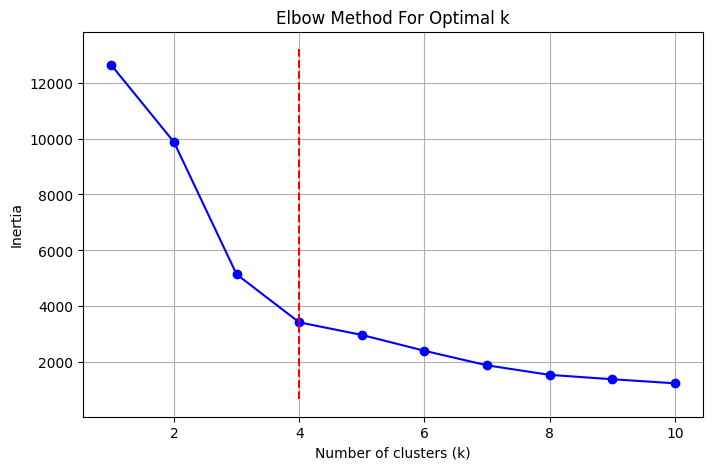

In [ ]:


sse = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)




knee = KneeLocator(K, sse, curve='convex', direction='decreasing')
print(f"Optimal k: {knee.knee}")


# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


#### Findings
- The Elbow plot shows the inertia decreasing as k increases.
- The `KneeLocator` identifies k=4 as the optimal number of clusters, representing a point where adding more clusters yields diminishing returns in reducing within-cluster variance.


#### 6.2.2 | Fitting K-Means and Adding Cluster Labels

# Fit KMeans with the optimal k=4

In [ ]:
# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_rfm_seg['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)
df_rfm_seg

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Segment,KMeans_Cluster
CustomerID,,,,,,,,,
12347,1,164,3243.33,4,4,4,12,Champions,0
12348,248,6,90.20,1,1,1,3,At Risk,3
12349,18,53,918.10,3,3,3,9,Loyal Customers,1
12350,309,16,294.40,1,2,2,5,Potential Loyalist,3
12352,35,66,866.01,3,3,3,9,Loyal Customers,1
...,...,...,...,...,...,...,...,...,...
18280,277,7,119.15,1,1,1,3,At Risk,3
18281,180,5,46.92,1,1,1,3,At Risk,3
18282,7,8,98.18,4,1,1,6,Potential Loyalist,1


#### Findings
- K-Means clustering with k=4 has been performed, and each customer is assigned to one of the four clusters (labeled 0 to 3).


In [ ]:
# Cluster profile (mean RFM values)
cluster_profile = df_rfm_seg.groupby(['KMeans_Cluster', 'Segment'])[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_profile)

                                      Recency    Frequency      Monetary
KMeans_Cluster Segment                                                  
0              Champions            13.379421   365.102894   4365.067556
               Loyal Customers     150.000000   478.000000   1401.560000
1              Champions            21.294243   111.752665   1388.473102
               Loyal Customers      46.437168    44.697345    550.247505
               Potential Loyalist   62.701282    12.592308    171.734644
2              Champions             1.400000  4104.400000  36688.292000
3              At Risk             261.148418     5.931873     84.225693
               Loyal Customers     222.268293    75.617886    879.143016
               Potential Loyalist  243.436149    24.056974    274.193752


In [ ]:
cluster_labels = {
    0: 'Loyal High-Value',
    1: 'Potential Loyalists',
    2: 'VIP Customers',
    3: 'Churned Customers'
}

df_rfm_seg['Segment'] = df_rfm_seg['KMeans_Cluster'].map(cluster_labels)


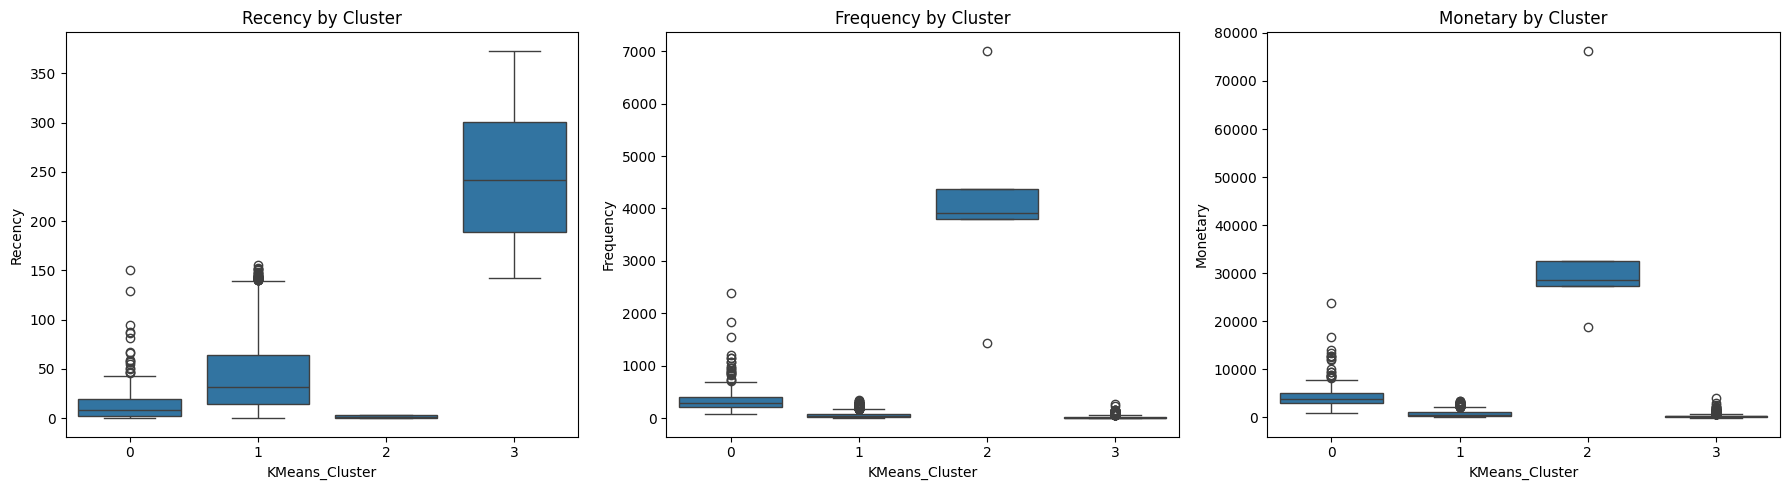

In [ ]:


# Boxplots for RFM distributions by cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(x='KMeans_Cluster', y=col, data=df_rfm_seg, ax=axes[i])
    axes[i].set_title(f'{col} by Cluster')
plt.tight_layout()
plt.show()


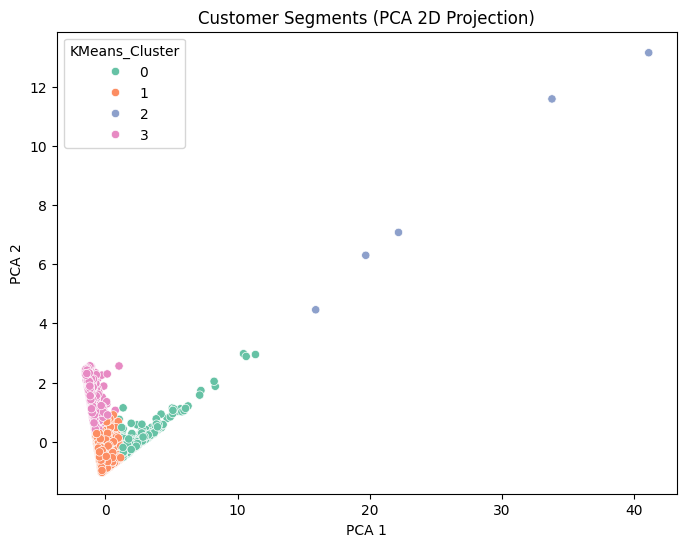

In [ ]:


pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=df_rfm_seg['KMeans_Cluster'], palette='Set2')
plt.title('Customer Segments (PCA 2D Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


### 6.3 | Hierarchical Clustering (Dendrogram)

### Description
Hierarchical clustering builds a hierarchy of clusters. A dendrogram visually represents this hierarchy, showing how clusters are merged (agglomerative) or split (divisive). The vertical axis represents the distance (or dissimilarity) at which clusters are merged. Long vertical lines suggest good points to "cut" the dendrogram to determine the number of clusters. The 'ward' linkage method minimizes the variance within each cluster.


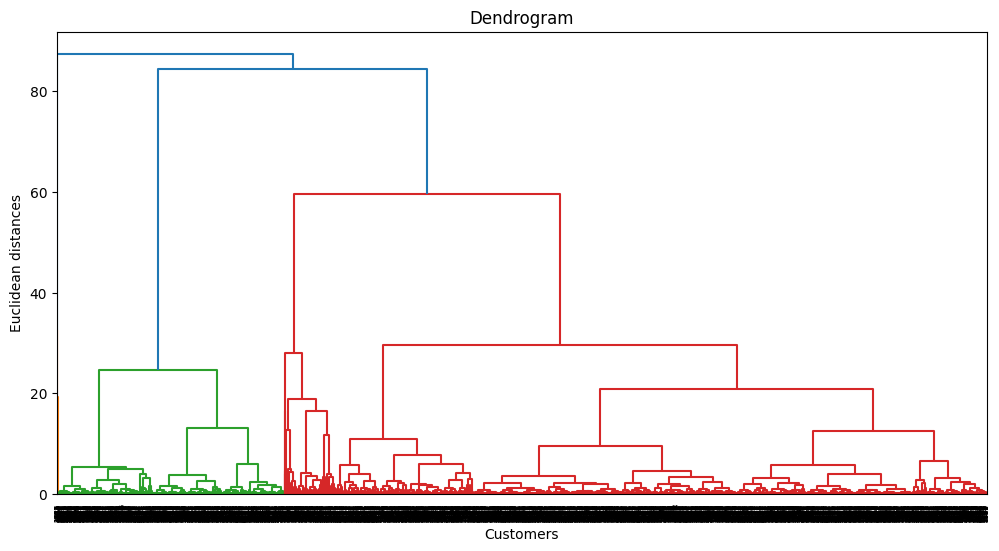

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean distances")
plt.show()

#### Findings
- The dendrogram visually suggests potential clusterings.
- Cutting the dendrogram at a high distance (e.g., around distance 100-120) clearly separates the data into 2 major groups.
- Cutting lower (e.g., around distance 60-80) suggests 3 distinct clusters (often represented by different colors in the plot by default).
- Cutting even lower (e.g., around 40-50) might suggest 4 or 5 clusters, aligning more closely with the K-Means elbow result.
- The visual evidence for 3 clusters seems quite strong based on the vertical distances between merges.


### 6.4 | Agglomerative Clustering

### Description
Agglomerative Clustering is the algorithm that typically produces the dendrogram. Here, we explicitly fit the model, specifying `n_clusters=3` based on the visual interpretation of the dendrogram, to compare its assignments with K-Means.


In [ ]:
agg = AgglomerativeClustering(n_clusters=3,  linkage='ward')
df_rfm_seg['Agglo_Cluster'] = agg.fit_predict(rfm_scaled)

df_rfm_seg

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Segment,KMeans_Cluster,Agglo_Cluster
CustomerID,,,,,,,,,,
12347,1,164,3243.33,4,4,4,12,Loyal High-Value,0,0
12348,248,6,90.20,1,1,1,3,Churned Customers,3,2
12349,18,53,918.10,3,3,3,9,Potential Loyalists,1,0
12350,309,16,294.40,1,2,2,5,Churned Customers,3,2
12352,35,66,866.01,3,3,3,9,Potential Loyalists,1,0
...,...,...,...,...,...,...,...,...,...,...
18280,277,7,119.15,1,1,1,3,Churned Customers,3,2
18281,180,5,46.92,1,1,1,3,Churned Customers,3,2
18282,7,8,98.18,4,1,1,6,Potential Loyalists,1,0


#### Findings
- Agglomerative clustering with k=3 has been performed, assigning each customer to one of three clusters (labeled 0 to 2).


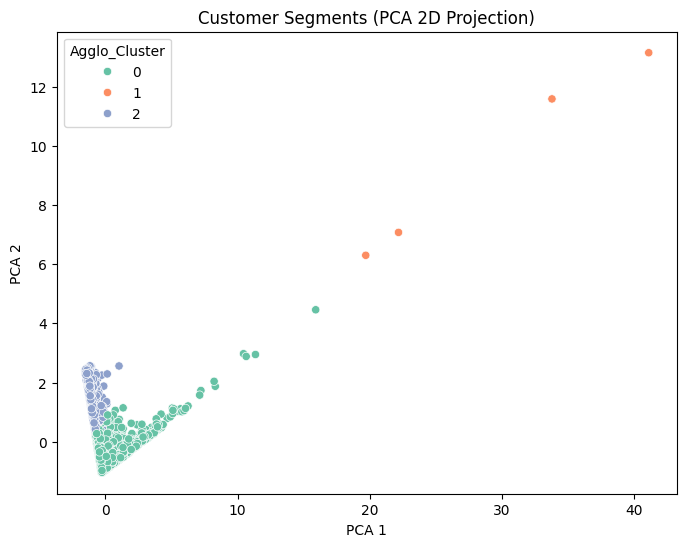

In [ ]:


pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=df_rfm_seg['Agglo_Cluster'], palette='Set2')
plt.title('Customer Segments (PCA 2D Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
cluster_profile = df_rfm_seg.groupby(['Agglo_Cluster'])[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_profile)

                  Recency    Frequency      Monetary
Agglo_Cluster                                       
0               40.403713    88.510384   1091.575341
1                1.000000  4770.500000  37715.757500
2              249.362573    22.726121    256.263169


In [ ]:
cluster_labels = {
    0: "Potential Loyalists",
    1: "VIP Customers",
    2: "At Risk"
}

df_rfm_seg['Agglo_Label'] = df_rfm_seg['Agglo_Cluster'].map(cluster_labels)
df_rfm_seg

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Segment,KMeans_Cluster,Agglo_Cluster,Agglo_Label
CustomerID,,,,,,,,,,,
12347,1,164,3243.33,4,4,4,12,Loyal High-Value,0,0,Potential Loyalists
12348,248,6,90.20,1,1,1,3,Churned Customers,3,2,At Risk
12349,18,53,918.10,3,3,3,9,Potential Loyalists,1,0,Potential Loyalists
12350,309,16,294.40,1,2,2,5,Churned Customers,3,2,At Risk
12352,35,66,866.01,3,3,3,9,Potential Loyalists,1,0,Potential Loyalists
...,...,...,...,...,...,...,...,...,...,...,...
18280,277,7,119.15,1,1,1,3,Churned Customers,3,2,At Risk
18281,180,5,46.92,1,1,1,3,Churned Customers,3,2,At Risk
18282,7,8,98.18,4,1,1,6,Potential Loyalists,1,0,Potential Loyalists


### 6.5 | DBSCAN Clustering

### Description
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. It groups together points that are closely packed, marking points in low-density regions as outliers (noise). Key parameters are `eps` (maximum distance between samples for one to be considered as in the neighborhood of the other) and `min_samples` (number of samples in a neighborhood for a point to be considered a core point).


In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
df_rfm_seg['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)
df_rfm_seg

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Segment,KMeans_Cluster,Agglo_Cluster,Agglo_Label,DBSCAN_Cluster
CustomerID,,,,,,,,,,,,
12347,1,164,3243.33,4,4,4,12,Loyal High-Value,0,0,Potential Loyalists,0
12348,248,6,90.20,1,1,1,3,Churned Customers,3,2,At Risk,0
12349,18,53,918.10,3,3,3,9,Potential Loyalists,1,0,Potential Loyalists,0
12350,309,16,294.40,1,2,2,5,Churned Customers,3,2,At Risk,0
12352,35,66,866.01,3,3,3,9,Potential Loyalists,1,0,Potential Loyalists,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18280,277,7,119.15,1,1,1,3,Churned Customers,3,2,At Risk,0
18281,180,5,46.92,1,1,1,3,Churned Customers,3,2,At Risk,0
18282,7,8,98.18,4,1,1,6,Potential Loyalists,1,0,Potential Loyalists,0


#### Findings
- With the chosen parameters (eps=0.8, min_samples=5), DBSCAN identifies one very large cluster (0), a very small cluster (1), and a few outliers (-1).
- This suggests that for these parameters, most customers are considered part of a single dense region based on their scaled RFM values.
- DBSCAN might require parameter tuning (especially `eps`) or might not be the most suitable algorithm if more granular segments are desired for this dataset.

In [ ]:
df_rfm_seg['DBSCAN_Cluster'].value_counts()

,count
DBSCAN_Cluster,
0,4184
-1,18
1,6


In [ ]:
df_rfm_seg.groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
DBSCAN_Cluster,,,
-1,27.111111,1845.055556,18465.009444
0,91.709847,67.916826,840.418239
1,8.500000,1051.666667,5689.231667


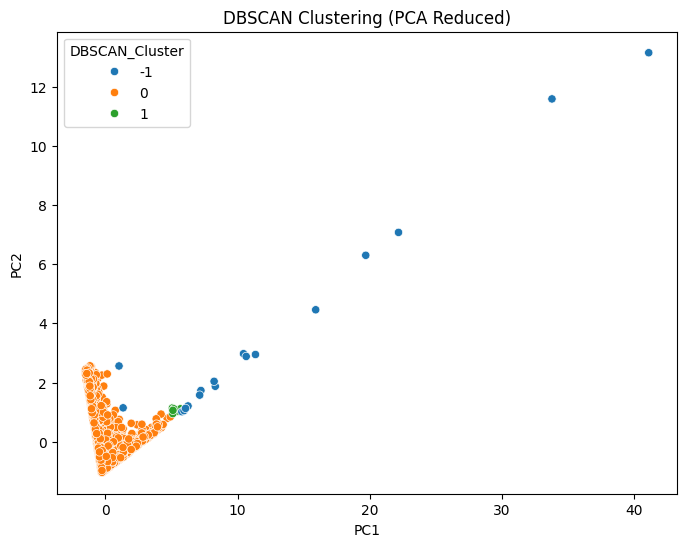

In [ ]:

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

df_rfm_seg['PC1'] = rfm_pca[:, 0]
df_rfm_seg['PC2'] = rfm_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_rfm_seg, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='tab10')
plt.title("DBSCAN Clustering (PCA Reduced)")
plt.show()


In [ ]:
cluster_labels = {
    0: 'General Customers',
    1: 'Elite Shoppers',
   -1: 'Outliers'
}

df_rfm_seg['DBSCAN_Label'] = df_rfm_seg['DBSCAN_Cluster'].map(cluster_labels)



# Step 7 | Clustering Evaluation

### Description
This section evaluates the quality of the clusters produced by K-Means, Agglomerative Clustering, and DBSCAN using internal validation metrics (Silhouette Score and Calinski-Harabasz Index) and by examining the RFM profiles of the resulting clusters.



### 7.1 | Internal Validation Metrics

In [ ]:
# For KMeans
sil_kmeans = silhouette_score(rfm_scaled, df_rfm_seg['KMeans_Cluster'])
print(f"KMeans Silhouette Score: {sil_kmeans:.3f}")

# For Agglomerative
sil_agglo = silhouette_score(rfm_scaled, df_rfm_seg['Agglo_Cluster'])
print(f"Agglomerative Silhouette Score: {sil_agglo:.3f}")

# For DBSCAN (ignore noise points i.e., -1)
dbscan_mask = df_rfm_seg['DBSCAN_Cluster'] != -1
sil_dbscan = silhouette_score(rfm_scaled[dbscan_mask], df_rfm_seg['DBSCAN_Cluster'][dbscan_mask])
print(f"DBSCAN Silhouette Score: {sil_dbscan:.3f}")


KMeans Silhouette Score: 0.589
Agglomerative Silhouette Score: 0.550
DBSCAN Silhouette Score: 0.743


In [ ]:
print("KMeans CH Index:", calinski_harabasz_score(rfm_scaled, df_rfm_seg['KMeans_Cluster']))
print("Agglomerative CH Index:", calinski_harabasz_score(rfm_scaled, df_rfm_seg['Agglo_Cluster']))
print("DBSCAN CH Index:", calinski_harabasz_score(rfm_scaled[dbscan_mask], df_rfm_seg['DBSCAN_Cluster'][dbscan_mask]))

KMeans CH Index: 3758.021971087321
Agglomerative CH Index: 2973.289734366188
DBSCAN CH Index: 125.08141782062543


#### Findings
- **Silhouette Score:** DBSCAN (excluding noise) achieves the highest score (0.743), suggesting good separation between its core clusters. KMeans (0.589) performs better than Agglomerative (0.550) with k=3. Higher scores indicate better-defined clusters.
- **Calinski-Harabasz Index:** K-Means (3758.02) significantly outperforms Agglomerative (2973.29) and especially DBSCAN (125.08). Higher CH scores indicate denser and better-separated clusters.
- **Overall:** K-Means shows strong performance based on the CH Index, while DBSCAN excels in Silhouette score (though it identified fewer distinct groups). Agglomerative (with k=3) performs reasonably but is slightly weaker than K-Means on both metrics used here.


### 7.2 | Cluster Profiling (Mean RFM Values)

### Description
To understand the characteristics of the clusters identified by each method, we calculate the average Recency, Frequency, and Monetary values for customers within each cluster. This helps in assigning meaningful business labels to the clusters. We exclude DBSCAN noise points (-1) from the mean calculation.

In [ ]:
df_rfm_seg.groupby('KMeans_Cluster')[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
KMeans_Cluster,,,
0,13.817308,365.464744,4355.569135
1,42.610604,57.989466,722.654660
2,1.400000,4104.400000,36688.292000
3,247.919463,22.995206,270.676866


In [ ]:
df_rfm_seg.groupby('Agglo_Cluster')[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
Agglo_Cluster,,,
0,40.403713,88.510384,1091.575341
1,1.000000,4770.500000,37715.757500
2,249.362573,22.726121,256.263169


In [ ]:
df_rfm_seg[df_rfm_seg['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
DBSCAN_Cluster,,,
0,91.709847,67.916826,840.418239
1,8.500000,1051.666667,5689.231667


#### Findings

- **KMeans (k=4):**
    - Cluster 0: Very low Recency, very high Frequency & Monetary (Best Customers / Champions).
    - Cluster 1: Low-moderate Recency, moderate Frequency & Monetary (Loyal / Regular Customers).
    - Cluster 2: Very low Recency, extremely high Frequency & Monetary (VIP / Top Tier Customers - small group).
    - Cluster 3: High Recency, very low Frequency & Monetary (At Risk / Churned / Low Value Customers).
- **Agglomerative (k=3):**
    - Cluster 0: Low-moderate Recency, moderate Frequency & Monetary (Likely combines KMeans Clusters 1 and some of 0).
    - Cluster 1: Extremely low Recency, extremely high Frequency & Monetary (VIP / Top Tier - similar to KMeans Cluster 2).
    - Cluster 2: High Recency, low Frequency & Monetary (At Risk / Churned - similar to KMeans Cluster 3).
- **DBSCAN (k=2 + Outliers):**
    - Cluster 0: Represents the bulk of customers with average RFM values.
    - Cluster 1: A very small group with low Recency and very high Frequency/Monetary (Likely some VIPs).
    - Outliers (-1): Have moderate Recency but extremely high Frequency/Monetary (Likely other VIPs/anomalies).

- **Comparison:** K-Means (k=4) provides the most granular and arguably interpretable segmentation among the three methods tested, capturing distinct groups like Champions, Regulars, VIPs, and At Risk customers. Agglomerative (k=3) offers a slightly broader view, while DBSCAN (with current parameters) mainly separates outliers and a small elite group from the rest.

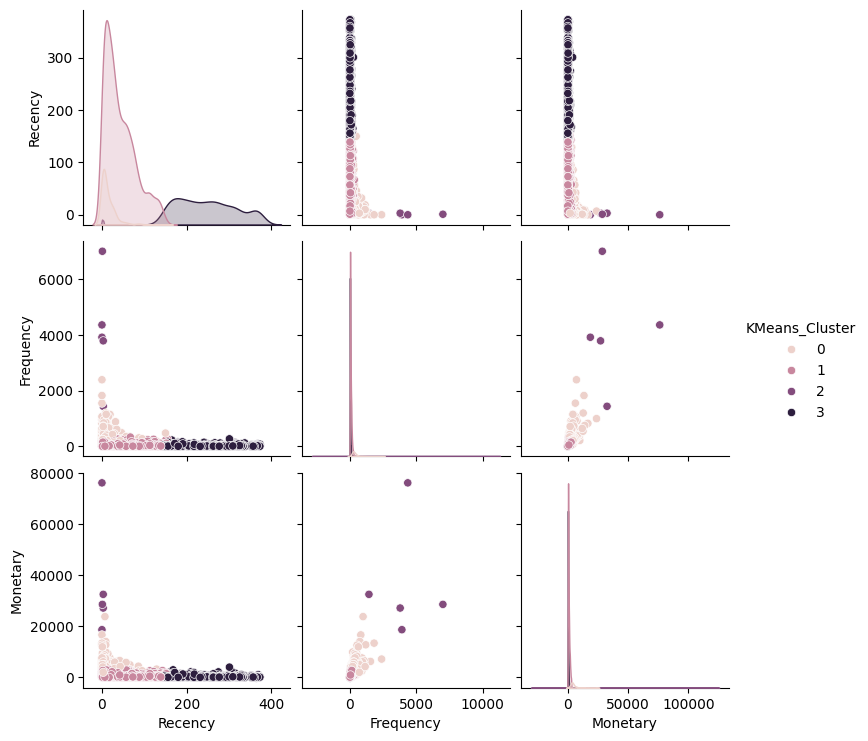

In [ ]:
# Visualize customer segments by cluster using pairplot
sns.pairplot(df_rfm_seg, hue='KMeans_Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.show()

# Step 8 | 📊 Clustering Evaluation Summary

#### **Silhouette Score (Higher is better)**
| Method           | Silhouette Score |
|------------------|------------------|
| KMeans           | 0.589            |
| Agglomerative    | 0.550            |
| **DBSCAN**       | **0.743** ✅       |

- **DBSCAN** shows the best separation and cohesion between clusters.

---

#### **Calinski-Harabasz (CH) Index (Higher is better)**
| Method           | CH Index         |
|------------------|------------------|
| **KMeans**       | **3758.02** ✅     |
| Agglomerative    | 2973.29          |
| DBSCAN           | 125.08 ❌          |

- **KMeans** has the most compact and well-separated clusters.

---

#### **Cluster Interpretability (RFM Analysis)**

**KMeans Clusters**
- Cluster 2: High frequency & monetary → **Loyal High Spenders**
- Cluster 0: Moderate frequency & good spending → **Regular Buyers**
- Cluster 1: Low frequency & low monetary → **Occasional Buyers**
- Cluster 3: High recency, low value → **Lost Customers**

**Agglomerative Clusters**
- Similar structure to KMeans but only 3 clusters.
- Less nuanced segmentation than KMeans.

**DBSCAN Clusters**
- Only 2 clusters:
  - Cluster 1: High frequency & value
  - Cluster 0: Lower value
- May be too coarse for business segmentation.

---

### ✅ **Conclusion: KMeans is the best overall**
- Competitive Silhouette Score
- Best CH Index
- Offers **rich and meaningful customer segments** (4 types)
- Balanced performance and interpretability


# Step 9 | Predictive Classifier for Customer Behavior

After segmenting the customers, you can create a predictive classifier to forecast future behaviors, such as whether a customer will make a purchase again, whether they will upgrade to a higher-value segment, or if they are at risk of churning.


###8.1 Labeling Customers for Classification
You can create labels for your classification model based on customer behavior. For example, let's predict High-Value Customers:

- High-Value Customers: Customers who have high monetary value (above the median).

- Low-Value Customers: Customers who have low monetary value (below the median).

In [ ]:
# Label customers as High-Value (1) or Low-Value (0) based on their monetary value
df_rfm['High_Value'] = (df_rfm['Monetary'] > df_rfm['Monetary'].median()).astype(int)
df_rfm

,Recency,Frequency,Monetary,High_Value
CustomerID,,,,
12347,1,164,3243.33,1
12348,248,6,90.20,0
12349,18,53,918.10,1
12350,309,16,294.40,0
12352,35,66,866.01,1
...,...,...,...,...
18280,277,7,119.15,0
18281,180,5,46.92,0
18282,7,8,98.18,0


In [ ]:
# Features and target variable
X = df_rfm[['Recency', 'Frequency', 'Monetary']]
y = df_rfm['High_Value']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Step 10 | Initialize Multiple Classification Models
We'll initialize several models, including:

- Logistic Regression

- Random Forest

- Support Vector Machine (SVM)

- Gradient Boosting

In [ ]:
logisticRegressionModel = LogisticRegression(random_state=42)
logisticRegressionModel.fit(X_train, y_train)
y_pred = logisticRegressionModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)


print("Model: Logistic Regression")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{confusion_mat}\n")

Model: Logistic Regression
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       432

    accuracy                           1.00       842
   macro avg       1.00      1.00      1.00       842
weighted avg       1.00      1.00      1.00       842

Confusion Matrix:
[[410   0]
 [  0 432]]



In [ ]:


RandomForestClassifierModel = RandomForestClassifier(random_state=42)
RandomForestClassifierModel.fit(X_train, y_train)
y_pred = RandomForestClassifierModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)


print("Model: Random Forest")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{confusion_mat}\n")




Model: Random Forest
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       432

    accuracy                           1.00       842
   macro avg       1.00      1.00      1.00       842
weighted avg       1.00      1.00      1.00       842

Confusion Matrix:
[[410   0]
 [  0 432]]



In [ ]:
SVCModel = SVC(random_state=42)
SVCModel.fit(X_train, y_train)
y_pred = SVCModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)


print("Model: Support Vector Machine")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{confusion_mat}\n")

Model: Support Vector Machine
Accuracy: 0.9928741092636579
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       410
           1       1.00      0.99      0.99       432

    accuracy                           0.99       842
   macro avg       0.99      0.99      0.99       842
weighted avg       0.99      0.99      0.99       842

Confusion Matrix:
[[410   0]
 [  6 426]]



In [ ]:
GradientBoostingClassifierModel = GradientBoostingClassifier(random_state=42)
GradientBoostingClassifierModel.fit(X_train, y_train)
y_pred = GradientBoostingClassifierModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)


print("Model: Gradient Boosting")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{confusion_mat}\n")

Model: Gradient Boosting
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       432

    accuracy                           1.00       842
   macro avg       1.00      1.00      1.00       842
weighted avg       1.00      1.00      1.00       842

Confusion Matrix:
[[410   0]
 [  0 432]]



#### Findings
- **Performance:** Logistic Regression, Random Forest, and Gradient Boosting achieve perfect (or near-perfect 1.0) accuracy and perfect precision/recall/F1-scores on the test set. SVM shows very high accuracy (0.9929) but misclassifies a few instances (6 False Negatives according to the matrix).
- **Interpretation:** The extremely high performance suggests that the task, as defined (predicting whether `Monetary` is above/below the median using R, F, *and* M as features), is very easy for the models. The `Monetary` feature itself is highly predictive of the target variable because the target is directly derived from it using a simple threshold (the median).
- **Caution:** This result might be misleading for a real-world prediction scenario. Predicting *future* high-value status based on *past* RFM would be a more challenging and realistic task. For this specific setup, the models have effectively learned the median threshold rule.


# Step 11 | Feature Importance (Random Forest)

### Description
Feature importance scores are extracted from the trained Random Forest model. This helps identify which of the RFM features (Recency, Frequency, Monetary) the model found most useful for predicting the `High_Value` target. The importances are plotted for visualization.

In [ ]:
feature_importance = RandomForestClassifierModel.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)



     Feature  Importance
2   Monetary    0.643779
1  Frequency    0.284186
0    Recency    0.072036


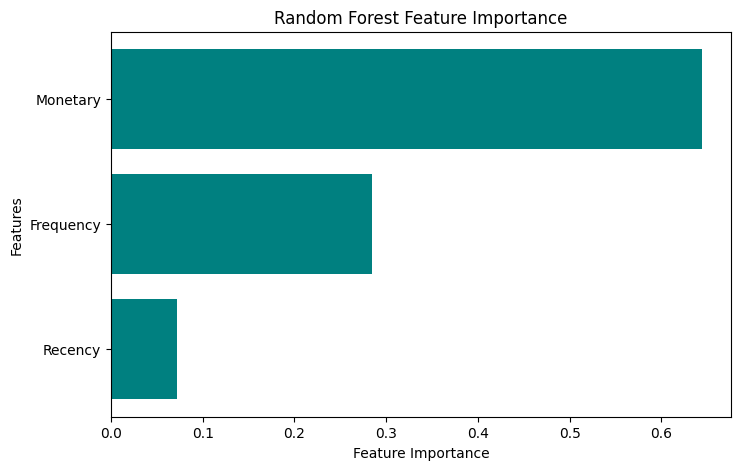

In [ ]:
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### Findings
- As anticipated from the high accuracy scores, **`Monetary`** is overwhelmingly the most important feature (importance ~0.64) for predicting the `High_Value` target. This is because the target variable was directly created based on the median of the `Monetary` value.
- `Frequency` has secondary importance (~0.28), suggesting that how often a customer purchases is somewhat correlated with their total spending being above or below the median.
- `Recency` has very low importance (~0.07) for this specific classification task, indicating that how recently a customer purchased is not a strong predictor of whether their total spending is above the median in this dataset setup.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

df_rfm['KMeans_Cluster'] = kmeans.labels_
df_rfm

,Recency,Frequency,Monetary,High_Value,KMeans_Cluster
CustomerID,,,,,
12347,1,164,3243.33,1,0
12348,248,6,90.20,0,3
12349,18,53,918.10,1,1
12350,309,16,294.40,0,3
12352,35,66,866.01,1,1
...,...,...,...,...,...
18280,277,7,119.15,0,3
18281,180,5,46.92,0,3
18282,7,8,98.18,0,1


# Step 11 | Model Saving

### Description
The trained K-Means clustering model, the StandardScaler used for RFM features before clustering, and the trained Random Forest classification model are saved to disk using `joblib`. This allows these components to be loaded and reused later without retraining, for example, in a deployment scenario or for further analysis.

In [ ]:
joblib.dump(kmeans, 'kmeans_customer_segmentation.pkl')
joblib.dump(scaler, 'rfm_scaler.pkl')

# Save the Random Forest model
joblib.dump(RandomForestClassifierModel, 'random_forest_model.pkl')

['random_forest_model.pkl']

# Actionable Insights and Marketing Strategies
With your segmentation model and predictive classifier in place, the next step is to develop marketing strategies based on the customer segments. Here are a few ideas:

- Targeted Marketing: Tailor campaigns based on the customer’s segment. For example, offer special discounts to loyal customers or re-engage at-risk customers with personalized offers.

- Retention Strategies: Focus on high-value customers by providing exclusive offers or loyalty programs to retain them.

- Inventory Management: Use the customer data to forecast demand for specific products and optimize inventory.